Test de schéma exponentiel sur les équations de Lorenz
===

> Il s'agit ici seulement de génération de code C++ pour tester les équations de Lorenz. La génération se fait pour différents schémas avec différents approximants de Padé. Il serait peut-être plus judicieux de convertir ce notebook en simple script (ou bibliothèque permettant d'écrire un schéma avec `sympy` et de le convertir en code C++ avec le choix de la méthode de Lawson avec différents approximants de Padé. Pour cela il peut être intéressant de regarder du côté d'un autre notebook où j'ai fait un *hack* pour pouvoir utiliser des exponentielles de matrices avec des `sympy.MatrixSymbol`, puis de les substituer par n'importe quel approximant de Padé ou la fonction exponentielle.

Les équations de Lorenz sont données par :

$$
  \begin{cases}
    \dot{x} = \sigma (y-x) \\
    \dot{y} = x(\rho-z)-y \\
    \dot{z} = xy-\beta z \\ 
  \end{cases}
$$

Soit de manière matricielle, en posant $u = \left(x\ y\ z\right)^T$ :

$$
  \dot{u} = 
  \begin{pmatrix}
    -\sigma & \sigma & 0 \\
    \rho    & -1     & 0 \\
    0       & 0      & -\beta \\
  \end{pmatrix} u
  +
  \begin{pmatrix}
    0 \\ -xz \\ xy
  \end{pmatrix}
$$

On note :
$$
  L = \begin{pmatrix}
    -\sigma & \sigma & 0 \\
    \rho    & -1     & 0 \\
    0       & 0      & -\beta \\
  \end{pmatrix}
  \qquad
  N:u\mapsto \begin{pmatrix}
    0 \\ -xz \\ xy
  \end{pmatrix}
$$

On peut ainsi écrire le schéma de Lawson RK(3,3) de Shu-Osher pour résoudre l'équation $\dot{u} = Lu + N(u)$ :

$$
  \begin{aligned}
    u^{(1)} &= \Delta t e^{L \Delta t} N{\left(u^{n} \right)} + u^{n} e^{L \Delta t} \\
    u^{(2)} &= \frac{\Delta t e^{- \frac{L \Delta t}{2}} N{\left(u^{(1)} \right)}}{4} + \frac{3 u^{n} e^{\frac{L \Delta t}{2}}}{4} + \frac{u^{(1)} e^{- \frac{L \Delta t}{2}}}{4} \\
    u^{n+1} &= \frac{2 \Delta t e^{\frac{L \Delta t}{2}} N{\left(u^{(2)} \right)}}{3} + \frac{u^{n} e^{L \Delta t}}{3} + \frac{2 u^{(2)} e^{\frac{L \Delta t}{2}}}{3}
  \end{aligned}
$$

On prendra les paramètres numériques suivant pour assurer le caractère chaotique du problème : $\sigma = 10$, $\beta=8/3$, $\rho=28$ et $u_0 = (1,1,1)$.

> Ce système est choisi car :
> * Il est multi-dimentionel ;
> * Il possède une partie linéaire et non-linéaire, ce qui permet la mise en place d'une méthode de Lawson ;
> * Le calcul de l'exponentielle de la matrice de la partie linéaire $\Delta t L$ est réalisable avec `sympy`, ce qui permettra de comparer la méthode de Lawson classique avec une méthode de Lawson-Padé, où l'exponentielle de la matrice est approchée par un approximant de Padé.

L'idée est donc de résoudre ce problème avec différentes méthodes de résolution :

* La méthode Runge-Kutta classique, qui nous servira de référence ;
* La méthode de Lawson induite par la même méthode Runge-Kutta que la résolution de référence ;
* La méthode de Lawson-Padé induite la par la méthode de Lawson précédente, en utilisant un approximant de Padé pour résoudre la partie linéaire du problème, ceci pouvant être effectué à différent ordre d'approximant de Padé.

In [1]:
import sympy as sp
x,y,z = sp.symbols("x y z")
u = sp.Matrix([x,y,z])

s,b,r = sp.symbols(r"\sigma \beta \rho")
L = sp.Matrix([
  [-s , s , 0],
  [ r ,-1 , 0],
  [ 0 , 0 ,-b]
])
def N(u):
  return sp.Matrix([
    0,
    -u[0]*u[2],
    u[0]*u[1]
  ])

In [2]:
dt = sp.symbols(r"\Delta\ t")

In [3]:
num_val = [(s,10),(b,sp.Rational(8,3)),(r,28)]

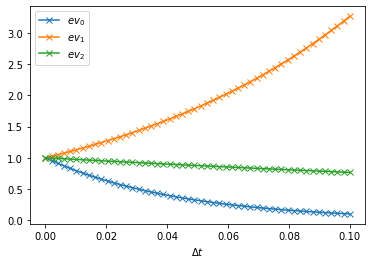

In [4]:
import numpy as np
import matplotlib.pyplot as plt
dts = np.linspace(1e-5,0.1)
for i,x in enumerate(sp.exp(dt*L).eigenvals()):
  plt.plot(dts,[x.subs(num_val).subs(dt,ndt).evalf() for ndt in dts ],"x-",label="$ev_{}$".format(i))
plt.xlabel(r"$\Delta t$")
plt.legend()
plt.show()

Donc nous ne sommes pas du tout dans un cas favorable pour les méthodes de Lawson, car les trois valeurs propres de la matrice $L$ sont réelles et une est plus grande que 1. Dans le cadre des équations de Lawson il n'y a pas de schéma en espace, donc pas de problème de stabilité.

Les équations de Lorenz, avec ces paramètres numériques, n'ont pas un comportement de divergence à l'infini, cela signifie, qu'en utilisant une méthode de Lawson nous résolvons exactement en temps un phénomène divergent, qui est compensé par la partie non-linéaire.

In [5]:
un_s,u1_s,u2_s = (sp.Matrix(sp.symbols(r"x^{%s} y^{%s} z^{%s}"%(stage,stage,stage))) for stage in ['n','(1)','(2)'])

u1 = sp.exp(dt*L)*un_s + dt*sp.exp(dt*L)*N(un_s)
u2 = sp.Rational(3,4)*sp.exp(sp.Rational(1,2)*dt*L)*un_s + sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*dt*L)*u1_s + dt*sp.Rational(1,4)*sp.exp(-sp.Rational(1,2)*dt*L)*N(u1_s)
un1= sp.Rational(1,3)*sp.exp(dt*L)*un_s + sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*dt*L)*u2_s + dt*sp.Rational(2,3)*sp.exp(sp.Rational(1,2)*dt*L)*N(u2_s)

display(u1)
display(u2)
display(un1)

Matrix([
[-\Delta t*x^{n}*z^{n}*(4*\rho*\sigma**2*exp(-\Delta t*(\sigma + 1)/2 + \Delta t*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)) + 2*\sigma*(2*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(-\Delta t*(\sigma + 1)/2 - \Delta t*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1))) + x^{n}*(2*\rho*\sigma*exp(-\Delta t*(\sigma + 1)/2 + \Delta t*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*sqrt(4*\rh

Matrix([
[-\Delta t*x^{(1)}*z^{(1)}*(4*\rho*\sigma**2*exp(\Delta t*(\sigma + 1)/4 + \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/((\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 + \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)) + 2*\sigma*(2*\rho*\sigma + \sigma**2 + \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(\Delta t*(\sigma + 1)/4 - \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 + \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)))/4 + x^{(1)}*(\rho*\sigma*exp(\Delta t*(\sigma + 1)/4 - \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/(2*(\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)

Matrix([
[-2*\Delta t*x^{(2)}*z^{(2)}*(4*\rho*\sigma**2*exp(-\Delta t*(\sigma + 1)/4 + \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/((\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)) + 2*\sigma*(2*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)*exp(-\Delta t*(\sigma + 1)/4 - \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/((\sigma - sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 1)*(4*\rho*\sigma + \sigma**2 - \sigma*sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) - 2*\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 1) + 1)))/3 + x^{(2)}*(4*\rho*\sigma*exp(-\Delta t*(\sigma + 1)/4 + \Delta t*sqrt(\rho*\sigma + \sigma**2/4 - \sigma/2 + 1/4)/2)/(3*(\sigma + sqrt(4*\rho*\sigma + \sigma**2 - 2*\sigma + 

In [6]:

sym_to_code = [
  (dt,sp.symbols("dt")),
  (sp.symbols("x^{n}"),sp.symbols("xn")),
  (sp.symbols("y^{n}"),sp.symbols("yn")),
  (sp.symbols("z^{n}"),sp.symbols("zn")),
  (sp.symbols("x^{(1)}"),sp.symbols("x1")),
  (sp.symbols("y^{(1)}"),sp.symbols("y1")),
  (sp.symbols("z^{(1)}"),sp.symbols("z1")),
  (sp.symbols("x^{(2)}"),sp.symbols("x2")),
  (sp.symbols("y^{(2)}"),sp.symbols("y2")),
  (sp.symbols("z^{(2)}"),sp.symbols("z2")),
]
func_to_code = []

def expr_to_code (expr,symbols_replace,function_replace):
  math_to_stl = [(f,"std::"+f) for f in ("sin","cos","exp","sqrt")]

  a = sp.Wild('a')
  
  tmp = sp.simplify(expr.subs(symbols_replace))
  for old,new in function_replace:
    tmp = tmp.replace(old,new)
  tmp = tmp.replace(a/2,0.5*a,exact=True).evalf()
  
  stmp = str(tmp)
  for old,new in math_to_stl:
    stmp = stmp.replace(old,new)
  return stmp

un_c,u1_c,u2_c,utmp_c = (sp.Matrix(sp.symbols(r"x%s y%s z%s"%(stage,stage,stage))) for stage in ['n','1','2','tmp'])

for us,stage in zip([u1_c,u2_c,utmp_c],[u1,u2,un1]):
  for xs,eq in zip(us,stage):
    print(str(xs)+" = "+expr_to_code(eq.subs(num_val).evalf(),sym_to_code,func_to_code)+";")
  print("//---")
for xtmp,xn in zip(utmp_c,un_c):
  print(str(xn)+" = "+str(xtmp)+";")

x1 = 1.0*(-0.288554928412381*dt*xn*zn*std::exp(1.0*std::sqrt(1201)*dt) + 0.288554928412381*dt*xn*zn + 0.370150282214429*xn*std::exp(1.0*std::sqrt(1201)*dt) + 0.629849717785571*xn + 0.288554928412381*yn*std::exp(1.0*std::sqrt(1201)*dt) - 0.288554928412381*yn)*std::exp(-0.5*dt*(11.0 + 1.0*std::sqrt(1201)));
y1 = 1.0*(-0.629849717785571*dt*xn*zn*std::exp(1.0*std::sqrt(1201)*dt) - 0.370150282214429*dt*xn*zn + 0.807953799554666*xn*std::exp(1.0*std::sqrt(1201)*dt) - 0.807953799554666*xn + 0.629849717785571*yn*std::exp(1.0*std::sqrt(1201)*dt) + 0.370150282214429*yn)*std::exp(-0.5*dt*(11.0 + 1.0*std::sqrt(1201)));
z1 = 1.0*(1.0*dt*xn*yn + 1.0*zn)*std::exp(-2.66666666666667*dt);
//---
x2 = 0.0721387321030952*dt*x1*z1*(-1.0*std::exp(0.25*dt*(11.0 - 1.0*std::sqrt(1201))) + 1.0*std::exp(0.25*dt*(11.0 + 1.0*std::sqrt(1201)))) + 1.0*x1*(0.0925375705536072*std::exp(0.25*dt*(11.0 - 1.0*std::sqrt(1201))) + 0.157462429446393*std::exp(0.25*dt*(11.0 + 1.0*std::sqrt(1201)))) + 1.0*xn*(0.277612711660822*std

In [7]:
def M(u):
  return sp.Matrix([
    s*(u[1]-u[0]),
    u[0]*(r-u[2])-u[1],
    u[0]*u[1]-b*u[2]
  ])

u1 = un_s + dt*M(un_s)
u2 = sp.Rational(3,4)*un_s + sp.Rational(1,4)*u1_s + dt*sp.Rational(1,4)*M(u1_s)
un1= sp.Rational(1,3)*un_s + sp.Rational(2,3)*u2_s + dt*sp.Rational(2,3)*M(u2_s)

display(u1)
display(u2)
display(un1)

Matrix([
[       \Delta t*\sigma*(-x^{n} + y^{n}) + x^{n}],
[\Delta t*(x^{n}*(\rho - z^{n}) - y^{n}) + y^{n}],
[  \Delta t*(-\beta*z^{n} + x^{n}*y^{n}) + z^{n}]])

Matrix([
[         \Delta t*\sigma*(-x^{(1)} + y^{(1)})/4 + x^{(1)}/4 + 3*x^{n}/4],
[\Delta t*(x^{(1)}*(\rho - z^{(1)}) - y^{(1)})/4 + y^{(1)}/4 + 3*y^{n}/4],
[  \Delta t*(-\beta*z^{(1)} + x^{(1)}*y^{(1)})/4 + z^{(1)}/4 + 3*z^{n}/4]])

Matrix([
[         2*\Delta t*\sigma*(-x^{(2)} + y^{(2)})/3 + 2*x^{(2)}/3 + x^{n}/3],
[2*\Delta t*(x^{(2)}*(\rho - z^{(2)}) - y^{(2)})/3 + 2*y^{(2)}/3 + y^{n}/3],
[  2*\Delta t*(-\beta*z^{(2)} + x^{(2)}*y^{(2)})/3 + 2*z^{(2)}/3 + z^{n}/3]])

In [8]:
for us,stage in zip([u1_c,u2_c,utmp_c],[u1,u2,un1]):
  for xs,eq in zip(us,stage):
    print(str(xs)+" = "+expr_to_code(eq.subs(num_val).evalf(),sym_to_code,func_to_code)+";")
  print("//---")
for xtmp,xn in zip(utmp_c,un_c):
  print(str(xn)+" = "+str(xtmp)+";")

x1 = -10.0*dt*(1.0*xn - 1.0*yn) + 1.0*xn;
y1 = -1.0*dt*(1.0*xn*(1.0*zn - 28.0) + 1.0*yn) + 1.0*yn;
z1 = 1.0*dt*(1.0*xn*yn - 2.66666666666667*zn) + 1.0*zn;
//---
x2 = -2.5*dt*(1.0*x1 - 1.0*y1) + 0.25*x1 + 0.75*xn;
y2 = -0.25*dt*(1.0*x1*(1.0*z1 - 28.0) + 1.0*y1) + 0.25*y1 + 0.75*yn;
z2 = 0.25*dt*(1.0*x1*y1 - 2.66666666666667*z1) + 0.25*z1 + 0.75*zn;
//---
xtmp = -6.66666666666667*dt*(1.0*x2 - 1.0*y2) + 0.666666666666667*x2 + 0.333333333333333*xn;
ytmp = -0.666666666666667*dt*(1.0*x2*(1.0*z2 - 28.0) + 1.0*y2) + 0.666666666666667*y2 + 0.333333333333333*yn;
ztmp = 0.666666666666667*dt*(1.0*x2*y2 - 2.66666666666667*z2) + 0.666666666666667*z2 + 0.333333333333333*zn;
//---
xn = xtmp;
yn = ytmp;
zn = ztmp;


In [9]:
def one(z):
  if isinstance(z,sp.Matrix) or isinstance(z,sp.ImmutableDenseMatrix):
    return sp.eye(z.cols)
  return 1
def zero(z):
  if isinstance(z,sp.Matrix) or isinstance(z,sp.ImmutableDenseMatrix):
    return sp.zeros(z.cols)
  return 0
def inv(z):
  if isinstance(z,sp.Matrix) or isinstance(z,sp.ImmutableDenseMatrix):
    return z.inv()
  return 1/z

def pade(n,m):
  def h(p,q):
    fac = sp.factorial
    return lambda x : sum([
      ((fac(p)/fac(p-i)).simplify()/(fac(p+q)/fac(p+q-i)).simplify()*one(x)*x**i/fac(i))
      for i in range(0,p+1)
    ],start=zero(x))

  def k(p,q):
    fac = sp.factorial
    return lambda x : sum([
      (-1)**j*(fac(q)/fac(q-j)).simplify()/(fac(p+q)/fac(p+q-j)).simplify()*one(x)*x**j/fac(j)
      for j in range(0,q+1)
    ],start=zero(x))
  
  return lambda z: h(n,m)(z)*inv(k(n,m)(z))

p_exp = pade(3,3)

In [10]:
nL = sp.simplify(L.subs(num_val))
t = sp.symbols("t",real=True,positive=True)
exp_nLt = pade(3,3)(t*nL)
exp_nLt

Matrix([
[            (-10948*t**3 - 3696*t**2 - 1680*t)*(391*t**3/12 - 11*t**2 + 5*t)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120) + (-3361*t**3 - 3372*t**2 - 60*t - 120)*(-172*t**3/3 + 38*t**2 - 5*t + 1)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120),             (-3910*t**3 - 1320*t**2 - 600*t)*(-172*t**3/3 + 38*t**2 - 5*t + 1)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120) + (391*t**3/12 - 11*t**2 + 5*t)*(-6880*t**3 - 4560*t**2 - 600*t - 120)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120),                                                                              0],
[(-10948*t**3 - 3696*t**2 - 1680*t)*(-3361*t**3/120 + 281*t**2/10 - t/2 + 1)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120) + (2737*t**3/30 - 154*t**2/5 + 14*t)*(-3361*t**3 - 3372*t**2 - 60*t - 120)/(164025*t**6 - 80190*t**5 + 1755*t**4 + 7579*t**3 + 168*t**2 - 660*t - 120

In [11]:
p_exp = lambda dt:exp_nLt.subs(t,dt)

In [12]:
u1 = p_exp(dt)*un_s + dt*p_exp(dt)*N(un_s)
u2 = sp.Rational(3,4)*p_exp(sp.Rational(1,2)*dt)*un_s + sp.Rational(1,4)*p_exp(-sp.Rational(1,2)*dt)*u1_s + dt*sp.Rational(1,4)*p_exp(-sp.Rational(1,2)*dt)*N(u1_s)
un1= sp.Rational(1,3)*p_exp(dt)*un_s + sp.Rational(2,3)*p_exp(sp.Rational(1,2)*dt)*u2_s + dt*sp.Rational(2,3)*p_exp(sp.Rational(1,2)*dt)*N(u2_s)

display(u1)
display(u2)
display(un1)

Matrix([
[                                    -\Delta t*x^{n}*z^{n}*((-3910*\Delta t**3 - 1320*\Delta t**2 - 600*\Delta t)*(-172*\Delta t**3/3 + 38*\Delta t**2 - 5*\Delta t + 1)/(164025*\Delta t**6 - 80190*\Delta t**5 + 1755*\Delta t**4 + 7579*\Delta t**3 + 168*\Delta t**2 - 660*\Delta t - 120) + (391*\Delta t**3/12 - 11*\Delta t**2 + 5*\Delta t)*(-6880*\Delta t**3 - 4560*\Delta t**2 - 600*\Delta t - 120)/(164025*\Delta t**6 - 80190*\Delta t**5 + 1755*\Delta t**4 + 7579*\Delta t**3 + 168*\Delta t**2 - 660*\Delta t - 120)) + x^{n}*((-10948*\Delta t**3 - 3696*\Delta t**2 - 1680*\Delta t)*(391*\Delta t**3/12 - 11*\Delta t**2 + 5*\Delta t)/(164025*\Delta t**6 - 80190*\Delta t**5 + 1755*\Delta t**4 + 7579*\Delta t**3 + 168*\Delta t**2 - 660*\Delta t - 120) + (-3361*\Delta t**3 - 3372*\Delta t**2 - 60*\Delta t - 120)*(-172*\Delta t**3/3 + 38*\Delta t**2 - 5*\Delta t + 1)/(164025*\Delta t**6 - 80190*\Delta t**5 + 1755*\Delta t**4 + 7579*\Delta t**3 + 168*\Delta t**2 - 660*\Delta t - 120)) + y

Matrix([
[                         -\Delta t*x^{(1)}*z^{(1)}*((-391*\Delta t**3/96 - 11*\Delta t**2/4 - 5*\Delta t/2)*(860*\Delta t**3 - 1140*\Delta t**2 + 300*\Delta t - 120)/(164025*\Delta t**6/64 + 40095*\Delta t**5/16 + 1755*\Delta t**4/16 - 7579*\Delta t**3/8 + 42*\Delta t**2 + 330*\Delta t - 120) + (1955*\Delta t**3/4 - 330*\Delta t**2 + 300*\Delta t)*(43*\Delta t**3/6 + 19*\Delta t**2/2 + 5*\Delta t/2 + 1)/(164025*\Delta t**6/64 + 40095*\Delta t**5/16 + 1755*\Delta t**4/16 - 7579*\Delta t**3/8 + 42*\Delta t**2 + 330*\Delta t - 120))/4 + x^{(1)}*((-391*\Delta t**3/96 - 11*\Delta t**2/4 - 5*\Delta t/2)*(2737*\Delta t**3/2 - 924*\Delta t**2 + 840*\Delta t)/(4*(164025*\Delta t**6/64 + 40095*\Delta t**5/16 + 1755*\Delta t**4/16 - 7579*\Delta t**3/8 + 42*\Delta t**2 + 330*\Delta t - 120)) + (43*\Delta t**3/6 + 19*\Delta t**2/2 + 5*\Delta t/2 + 1)*(3361*\Delta t**3/8 - 843*\Delta t**2 + 30*\Delta t - 120)/(4*(164025*\Delta t**6/64 + 40095*\Delta t**5/16 + 1755*\Delta t**4/16 - 7579*\De

Matrix([
[                                       -2*\Delta t*x^{(2)}*z^{(2)}*((-1955*\Delta t**3/4 - 330*\Delta t**2 - 300*\Delta t)*(-43*\Delta t**3/6 + 19*\Delta t**2/2 - 5*\Delta t/2 + 1)/(164025*\Delta t**6/64 - 40095*\Delta t**5/16 + 1755*\Delta t**4/16 + 7579*\Delta t**3/8 + 42*\Delta t**2 - 330*\Delta t - 120) + (391*\Delta t**3/96 - 11*\Delta t**2/4 + 5*\Delta t/2)*(-860*\Delta t**3 - 1140*\Delta t**2 - 300*\Delta t - 120)/(164025*\Delta t**6/64 - 40095*\Delta t**5/16 + 1755*\Delta t**4/16 + 7579*\Delta t**3/8 + 42*\Delta t**2 - 330*\Delta t - 120))/3 + x^{(2)}*(2*(-2737*\Delta t**3/2 - 924*\Delta t**2 - 840*\Delta t)*(391*\Delta t**3/96 - 11*\Delta t**2/4 + 5*\Delta t/2)/(3*(164025*\Delta t**6/64 - 40095*\Delta t**5/16 + 1755*\Delta t**4/16 + 7579*\Delta t**3/8 + 42*\Delta t**2 - 330*\Delta t - 120)) + 2*(-3361*\Delta t**3/8 - 843*\Delta t**2 - 30*\Delta t - 120)*(-43*\Delta t**3/6 + 19*\Delta t**2/2 - 5*\Delta t/2 + 1)/(3*(164025*\Delta t**6/64 - 40095*\Delta t**5/16 + 1755*\

In [13]:
func_to_code.append((sp.Pow,sp.Function("std::pow",nargs=2)))

for us,stage in zip([u1_c,u2_c,utmp_c],[u1,u2,un1]):
  for xs,eq in zip(us,stage):
    print(str(xs)+" = "+expr_to_code(eq.subs(num_val).evalf(),sym_to_code,func_to_code)+";")
  print("//---")
for xtmp,xn in zip(utmp_c,un_c):
  print(str(xn)+" = "+str(xtmp)+";")

x1 = 1.0*(540.0*dt*xn - 1200.0*dt*yn + 1200.0*xn*zn*std::pow(1.0*dt, 2) + 40220.0*xn*zn*std::pow(1.0*dt, 4) + 145800.0*xn*zn*std::pow(1.0*dt, 6) - 16032.0*xn*std::pow(1.0*dt, 2) + 18099.0*xn*std::pow(1.0*dt, 3) - 176715.0*xn*std::pow(1.0*dt, 4) + 65610.0*xn*std::pow(1.0*dt, 5) - 164025.0*xn*std::pow(1.0*dt, 6) - 120.0*xn - 40220.0*yn*std::pow(1.0*dt, 3) - 145800.0*yn*std::pow(1.0*dt, 5))*std::pow(-660.0*dt + 168.0*std::pow(1.0*dt, 2) + 7579.0*std::pow(1.0*dt, 3) + 1755.0*std::pow(1.0*dt, 4) - 80190.0*std::pow(1.0*dt, 5) + 164025.0*std::pow(1.0*dt, 6) - 120.0, -1);
y1 = 1.0*(120.0*dt*xn*zn - 3360.0*dt*xn - 540.0*dt*yn + 540.0*xn*zn*std::pow(1.0*dt, 2) + 16032.0*xn*zn*std::pow(1.0*dt, 3) + 18099.0*xn*zn*std::pow(1.0*dt, 4) + 176715.0*xn*zn*std::pow(1.0*dt, 5) + 65610.0*xn*zn*std::pow(1.0*dt, 6) + 164025.0*xn*zn*std::pow(1.0*dt, 7) - 112616.0*xn*std::pow(1.0*dt, 3) - 408240.0*xn*std::pow(1.0*dt, 5) - 16032.0*yn*std::pow(1.0*dt, 2) - 18099.0*yn*std::pow(1.0*dt, 3) - 176715.0*yn*std::pow(1.

ytmp = 1.0*(-0.333333333333333*(1.0*dt*xn*(1.0*(-30.8*dt + 91.2333333333333*std::pow(1.0*dt, 2) + 14.0)*(60.0*dt + 3372.0*std::pow(1.0*dt, 2) + 3361.0*std::pow(1.0*dt, 3) + 120.0) - 1.0*(3696.0*dt + 10948.0*std::pow(1.0*dt, 2) + 1680.0)*(0.5*dt - 28.1*std::pow(1.0*dt, 2) + 28.0083333333333*std::pow(1.0*dt, 3) - 1.0)) + 1.0*yn*(1.0*(-30.8*dt + 91.2333333333333*std::pow(1.0*dt, 2) + 14.0)*(1320.0*dt + 3910.0*std::pow(1.0*dt, 2) + 600.0)*std::pow(1.0*dt, 2) - 1.0*(0.5*dt - 28.1*std::pow(1.0*dt, 2) + 28.0083333333333*std::pow(1.0*dt, 3) - 1.0)*(600.0*dt + 4560.0*std::pow(1.0*dt, 2) + 6880.0*std::pow(1.0*dt, 3) + 120.0)))*(-330.0*dt + 42.0*std::pow(1.0*dt, 2) + 947.375*std::pow(1.0*dt, 3) + 109.6875*std::pow(1.0*dt, 4) - 2505.9375*std::pow(1.0*dt, 5) + 2562.890625*std::pow(1.0*dt, 6) - 120.0) + 0.666666666666667*(1.0*dt*x2*z2*(1.0*(-7.7*dt + 11.4041666666667*std::pow(1.0*dt, 2) + 7.0)*(330.0*dt + 488.75*std::pow(1.0*dt, 2) + 300.0)*std::pow(1.0*dt, 2) - 1.0*(0.25*dt - 7.025*std::pow(1.0*dt,

In [14]:
exp_nLt = pade(9,9)(t*nL)
p_exp = lambda dt:exp_nLt.subs(t,dt)

u1 = p_exp(dt)*un_s + dt*p_exp(dt)*N(un_s)
u2 = sp.Rational(3,4)*p_exp(sp.Rational(1,2)*dt)*un_s + sp.Rational(1,4)*p_exp(-sp.Rational(1,2)*dt)*u1_s + dt*sp.Rational(1,4)*p_exp(-sp.Rational(1,2)*dt)*N(u1_s)
un1= sp.Rational(1,3)*p_exp(dt)*un_s + sp.Rational(2,3)*p_exp(sp.Rational(1,2)*dt)*u2_s + dt*sp.Rational(2,3)*p_exp(sp.Rational(1,2)*dt)*N(u2_s)

for us,stage in zip([u1_c,u2_c,utmp_c],[u1,u2,un1]):
  for xs,eq in zip(us,stage):
    print(str(xs)+" = "+expr_to_code(eq.subs(num_val).evalf(),sym_to_code,func_to_code)+";")
  print("//---")
for xtmp,xn in zip(utmp_c,un_c):
  print(str(xn)+" = "+str(xtmp)+";")

x1 = 1.0*(1.3510564651584e+15*dt*xn - 3.002347700352e+15*dt*yn + 3.002347700352e+15*xn*zn*std::pow(1.0*dt, 2) + 1.35650189971296e+17*xn*zn*std::pow(1.0*dt, 4) + 1.56390443380211e+18*xn*zn*std::pow(1.0*dt, 6) - 64.0*xn*zn*std::pow(1.0*dt, 7) + 7.01886385188228e+18*xn*zn*std::pow(1.0*dt, 8) - 1024.0*xn*zn*std::pow(1.0*dt, 9) + 1.42429862196713e+19*xn*zn*std::pow(1.0*dt, 10) - 1536.0*xn*zn*std::pow(1.0*dt, 11) + 1.36347773479928e+19*xn*zn*std::pow(1.0*dt, 12) - 4096.0*xn*zn*std::pow(1.0*dt, 13) + 5.96326071319382e+18*xn*zn*std::pow(1.0*dt, 14) - 2048.0*xn*zn*std::pow(1.0*dt, 15) + 1.04315118999299e+18*xn*zn*std::pow(1.0*dt, 16) + 4.90329056390623e+16*xn*zn*std::pow(1.0*dt, 18) + 64.0*xn*zn*std::pow(1.0*dt, 19) - 4.36135155648192e+16*xn*std::pow(1.0*dt, 2) + 6.10425854870832e+16*xn*std::pow(1.0*dt, 3) - 9.12552021713012e+17*xn*std::pow(1.0*dt, 4) + 7.0375699521095e+17*xn*std::pow(1.0*dt, 5) - 6.37788870264041e+18*xn*std::pow(1.0*dt, 6) + 3.15848873334703e+18*xn*std::pow(1.0*dt, 7) - 1.9046

y2 = 1.0*(0.75*(1.0*dt*xn*(1.0*(-9.05882352941176*dt + 23.4791666666667*std::pow(1.0*dt, 2) - 21.8308210784314*std::pow(1.0*dt, 3) + 19.896706495098*std::pow(1.0*dt, 4) - 11.0096220619658*std::pow(1.0*dt, 5) + 4.62236200469771*std::pow(1.0*dt, 6) - 1.18100100479394*std::pow(1.0*dt, 7) + 0.150962545070008*std::pow(1.0*dt, 8) + 7.0)*(75058692508800.0*dt + 2.4813520699968e+15*std::pow(1.0*dt, 2) + 2.1641003169786e+15*std::pow(1.0*dt, 3) + 3.63283611824133e+15*std::pow(1.0*dt, 4) + 2.47059112785235e+15*std::pow(1.0*dt, 5) + 1.59506210558945e+15*std::pow(1.0*dt, 6) + 618745992590664.0*std::pow(1.0*dt, 7) + 164735044631697.0*std::pow(1.0*dt, 8) + 20613948308267.8*std::pow(1.0*dt, 9) + 300234770035200.0) - 1.0*(2.7197737991424e+15*dt + 7.0492622047848e+15*std::pow(1.0*dt, 2) + 6.55437154616244e+15*std::pow(1.0*dt, 3) + 5.97368309901363e+15*std::pow(1.0*dt, 4) + 3.30547134794877e+15*std::pow(1.0*dt, 5) + 1.38779379349986e+15*std::pow(1.0*dt, 6) + 354577565085650.0*std::pow(1.0*dt, 7) + 4532420

z2 = -1.0*(508698646706.25*zn*(0.666666666666667*dt - 0.209150326797386*std::pow(1.0*dt, 2) + 0.0406681190994916*std::pow(1.0*dt, 3) - 0.00542241587993222*std::pow(1.0*dt, 4) + 0.000516420559993545*std::pow(1.0*dt, 5) - 3.53108075209261e-5*std::pow(1.0*dt, 6) + 1.68146702480601e-6*std::pow(1.0*dt, 7) - 5.09535462062426e-8*std::pow(1.0*dt, 8) + 7.54867351203594e-10*std::pow(1.0*dt, 9) - 1.0)*(452176574850.0*dt - 141859317600.0*std::pow(1.0*dt, 2) + 27583756200.0*std::pow(1.0*dt, 3) - 3677834160.0*std::pow(1.0*dt, 4) + 350269920.0*std::pow(1.0*dt, 5) - 23950080.0*std::pow(1.0*dt, 6) + 1140480.0*std::pow(1.0*dt, 7) - 34560.0*std::pow(1.0*dt, 8) + 512.0*std::pow(1.0*dt, 9) - 678264862275.0) + 1.0*(1.0*dt*x1*y1 + 1.0*z1)*(113044143712.5*dt + 35464829400.0*std::pow(1.0*dt, 2) + 6895939050.0*std::pow(1.0*dt, 3) + 919458540.0*std::pow(1.0*dt, 4) + 87567480.0*std::pow(1.0*dt, 5) + 5987520.0*std::pow(1.0*dt, 6) + 285120.0*std::pow(1.0*dt, 7) + 8640.0*std::pow(1.0*dt, 8) + 128.0*std::pow(1.0*dt, 

ytmp = 1.0*(0.333333333333333*(1.0*dt*xn*(1.0*(-36.2352941176471*dt + 187.833333333333*std::pow(1.0*dt, 2) - 349.293137254902*std::pow(1.0*dt, 3) + 636.694607843137*std::pow(1.0*dt, 4) - 704.615811965812*std::pow(1.0*dt, 5) + 591.662336601307*std::pow(1.0*dt, 6) - 302.33625722725*std::pow(1.0*dt, 7) + 77.2928230758439*std::pow(1.0*dt, 8) + 14.0)*(150117385017600.0*dt + 9.9254082799872e+15*std::pow(1.0*dt, 2) + 1.73128025358288e+16*std::pow(1.0*dt, 3) + 5.81253778918613e+16*std::pow(1.0*dt, 4) + 7.90589160912751e+16*std::pow(1.0*dt, 5) + 1.02083974757725e+17*std::pow(1.0*dt, 6) + 7.91994870516049e+16*std::pow(1.0*dt, 7) + 4.21721714257143e+16*std::pow(1.0*dt, 8) + 1.05543415338331e+16*std::pow(1.0*dt, 9) + 300234770035200.0) - 1.0*(1.08790951965696e+16*dt + 5.63940976382784e+16*std::pow(1.0*dt, 2) + 1.04869944738599e+17*std::pow(1.0*dt, 3) + 1.91157859168436e+17*std::pow(1.0*dt, 4) + 2.11550166268721e+17*std::pow(1.0*dt, 5) + 1.77637605567983e+17*std::pow(1.0*dt, 6) + 9.07718566619264e+

ztmp = -1.0*(226088287425.0*zn*(1.33333333333333*dt - 0.836601307189543*std::pow(1.0*dt, 2) + 0.325344952795933*std::pow(1.0*dt, 3) - 0.0867586540789155*std::pow(1.0*dt, 4) + 0.0165254579197934*std::pow(1.0*dt, 5) - 0.00225989168133927*std::pow(1.0*dt, 6) + 0.000215227779175169*std::pow(1.0*dt, 7) - 1.30441078287981e-5*std::pow(1.0*dt, 8) + 3.8649208381624e-7*std::pow(1.0*dt, 9) - 1.0)*(452176574850.0*dt + 141859317600.0*std::pow(1.0*dt, 2) + 27583756200.0*std::pow(1.0*dt, 3) + 3677834160.0*std::pow(1.0*dt, 4) + 350269920.0*std::pow(1.0*dt, 5) + 23950080.0*std::pow(1.0*dt, 6) + 1140480.0*std::pow(1.0*dt, 7) + 34560.0*std::pow(1.0*dt, 8) + 512.0*std::pow(1.0*dt, 9) + 678264862275.0) + 1.0*(1.0*dt*x2*y2 + 1.0*z2)*(301451049900.0*dt - 94572878400.0*std::pow(1.0*dt, 2) + 18389170800.0*std::pow(1.0*dt, 3) - 2451889440.0*std::pow(1.0*dt, 4) + 233513280.0*std::pow(1.0*dt, 5) - 15966720.0*std::pow(1.0*dt, 6) + 760320.0*std::pow(1.0*dt, 7) - 23040.0*std::pow(1.0*dt, 8) + 341.333333333333*std::p